In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt

% matplotlib inline

import sys
sys.path.append("..")

In [2]:
import rascals

rascals.setupOorb()
config = rascals.Config()

In [3]:
DATABASE = "../data/objects.db"
con = sql.connect(DATABASE)

#### Cell and Query Code

In [4]:
class Cell:
    
    def __init__(self, center, mjdRange, totalRadius=10):
        self.center = center
        self.totalRadius = totalRadius
        self.mjdRange = mjdRange
        self.observations = None
        self.xRange = [center[0] - totalRadius, center[0] + totalRadius]
        self.yRange = [center[1] - totalRadius, center[1] + totalRadius]
        
    def gatherObservations(self,
                           con,
                           queryType="truth",
                           observationColumns=config.observationColumns,
                           truthColumns=config.truthColumns):
        
        query = createQuery(queryType,
                            observationColumns=observationColumns,
                            truthColumns=truthColumns)
        
        # TODO: implement concentric circles 
        self.observations = pd.read_sql("""SELECT {0} FROM ephemeris
                                     WHERE (({1} >= {2} AND {1} <= {3})
                                     AND ({4} >= {5} AND {4} <= {6})
                                     AND ({7} >= {8} AND {7} <= {9}))""".format(query,
                                                                                observationColumns["exp_mjd"],
                                                                                *self.mjdRange,
                                                                                observationColumns["RA_deg"],
                                                                                *self.xRange,
                                                                                observationColumns["Dec_deg"],
                                                                                *self.yRange), con)
        columnMapping = {**observationColumns, **truthColumns}
        inverseMapping = {value : key for key, value in columnMapping.items()}
        self.observations.rename(columns=inverseMapping, inplace=True)        
        print("Found {} observations.".format(len(self.observations)))
        return
        
    def selectObservations(self, center, radius, night):
    
        night_obs = self.observations[self.observations["night"] == night]
        keep = rascals.findObsInCell(night_obs["obs_id"].values,
                                     night_obs[["RA_deg", "Dec_deg"]].as_matrix(),
                                     center,
                                     radius)
        night_obs = night_obs[night_obs["obs_id"].isin(keep)]
        return night_obs
    

def createQuery(queryType,
                observationColumns=config.observationColumns,
                truthColumns=config.truthColumns):
    if queryType == "observation":
        columns = list(config.observationColumns.values())
    elif queryType == "truth":
        columns = list(config.observationColumns.values()) + list(config.truthColumns.values())
    else:
        raise ValueError("queryType should be one of 'observation' or 'truth'")
    query = '"' + '", "'.join(columns) + '"'
    return query

def queryNight(con,
               night,
               queryType="observation",
               observationColumns=config.observationColumns,
               truthColumns=config.truthColumns):
    
    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    night_df = pd.read_sql("""SELECT {} FROM ephemeris
                              WHERE night = {}""".format(query, night), con)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    night_df.rename(columns=inverseMapping, inplace=True)
    return night_df

def queryCell(con,
              cell,
              queryType="observation",
              chunksize=50000,
              observationColumns=config.observationColumns,
              truthColumns=config.truthColumns):

    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    
    chunks = []
    for chunk in pd.read_sql("""SELECT {0} FROM ephemeris
                                 WHERE (({1} >= {2} AND {1} <= {3})
                                 AND ({4} >= {5} AND {4} <= {6})
                                 AND ({7} >= {8} AND {7} <= {9}))""".format(query,
                                                                            observationColumns["exp_mjd"],
                                                                            *cell.mjdRange,
                                                                            observationColumns["RA_deg"],
                                                                            *cell.xRange,
                                                                            observationColumns["Dec_deg"],
                                                                            *cell.yRange), 
                             con,
                             chunksize=chunksize):
        chunks.append(chunk)
    
    cell_df = pd.concat(chunks)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    cell_df.rename(columns=inverseMapping, inplace=True)                                                                    

    keep = rascals.findObsInCell(cell_df["obs_id"].values,
                                 cell_df[["RA_deg", "Dec_deg"]].as_matrix(),
                                 cell.center,
                                 cell.radius)
    cell_df = cell_df[cell_df["obs_id"].isin(keep)]
    return cell_df


#### Plotting Code

In [5]:
def _setAxes(ax, coordinateSystem):
    """
    Helper function to set axes limits depending on the coordinate system.
    
    """
    if coordinateSystem == "equatorialAngular":
        ax.set_xlabel(r"$\alpha$ [deg]")
        ax.set_ylabel(r"$\delta$ [deg]")
    elif coordinateSystem == "eclipticAngular":
        ax.set_xlabel(r"$\lambda$ [deg]")
        ax.set_ylabel(r"$\beta$ [deg]")
    elif coordinateSystem == "gnomonic":
        ax.set_xlabel(r"$\theta_X$ [deg]")
        ax.set_ylabel(r"$\theta_Y$ [deg]")
    else:
        raise ValueError("coordinateSystem should be one of: 'equatorialAngular', 'eclipticAngular', 'tangentPlane'")

def plotCell(cell,
             coordinateSystem="equatorialAngular",
             scatterKwargs={"s":0.05}):
        
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = cell.observations["RA_deg"].values, 
        y = cell.observations["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = cell.observationst["lon_deg"].values, 
        y = cell.observations["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    ax.set_xlim(*cell.xRange)
    ax.set_ylim(*cell.yRange)
    
    cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
    ax.add_artist(cell_p)
    ax.grid()
    return
    
def plotNight(night,
              cell=None,
              coordinateSystem="equatorialAngular",
              scatterKwargs={"s":0.05},
              scatterXlims=(0, 360),
              scatterYlims=(-90, 90)):
    
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = night["RA_deg"].values, 
        y = night["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = night["lon_deg"].values, 
        y = night["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    ax.set_xlim(scatterXlims)
    ax.set_ylim(scatterYlims)

    if cell is not None:
        cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
        ax.add_artist(cell_p)

    ax.grid()
    return

In [6]:
night = queryNight(con, 59582)

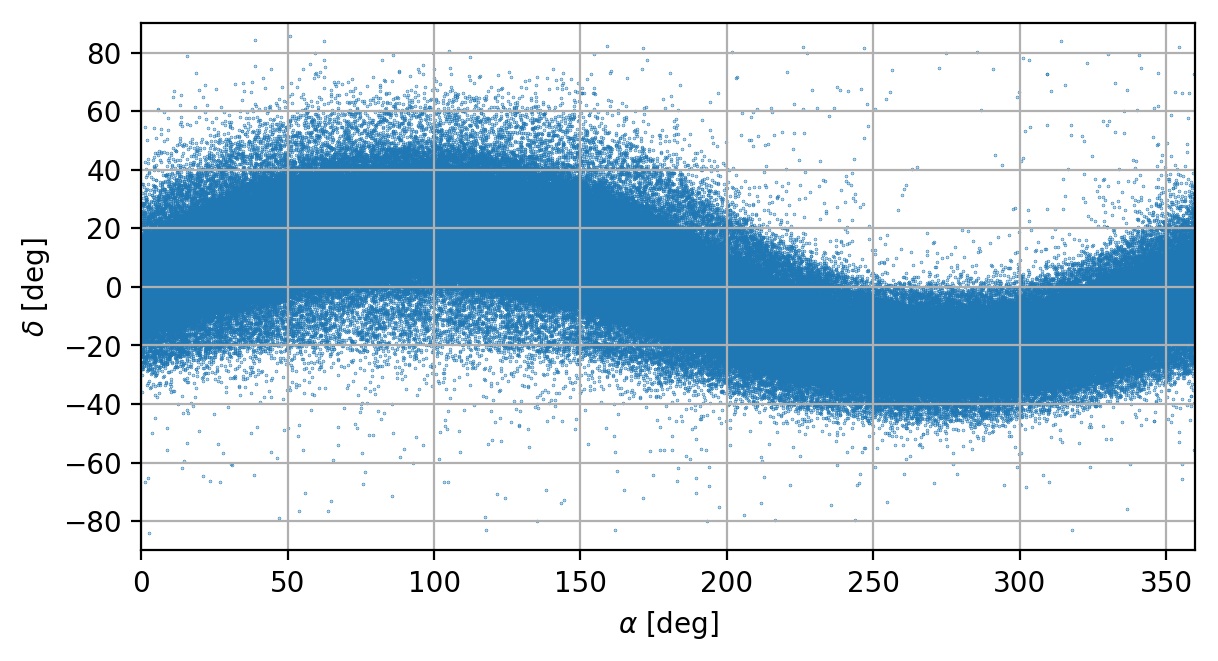

In [7]:
plotNight(night)

In [8]:
cell = Cell([199.8, -19.8], [59582, 59582+10])

In [9]:
cell.gatherObservations(con)

Found 176218 observations.


#### Guessing Barycentric Distance

In [10]:
radius = 1.0
firstnight = cell.selectObservations(cell.center, radius, 59582)

In [11]:
print("r [AU]:\n min: {}\n max: {}\n median: {}".format(cell.observations["r_au"].min(),
                                                        cell.observations["r_au"].max(),
                                                        cell.observations["r_au"].median()))

r [AU]:
 min: 0.0002701889
 max: 9.9988090614
 median: 2.81831496695


In [12]:
# For now lets take the object which has the median barycentric distance, lets also grab its velocity
real_object = cell.observations[cell.observations["name"] == "U3160"]
real_object_velocity_ec_cart = real_object[["obj_dx/dt_au_p_day", "obj_dy/dt_au_p_day", "obj_dz/dt_au_p_day"]].as_matrix()[0]
real_object_x_e = real_object[["obs_x_au","obs_y_au", "obs_z_au"]].as_matrix()[0]
print(real_object_velocity_ec_cart)

[-0.00080995 -0.01203773 -0.00112666]


In [13]:
real_object

,obs_id,exp_mjd,night,RA_deg,Dec_deg,obs_x_au,obs_y_au,obs_z_au,mag,name,Delta_au,r_au,obj_x_au,obj_y_au,obj_z_au,obj_dx/dt_au_p_day,obj_dy/dt_au_p_day,obj_dz/dt_au_p_day
68236,9397932,59582.173,59582,199.792117,-19.786006,-0.211947,0.960252,-0.000078,21.187089,U3160,2.323884,2.309560,-2.269464,-0.031994,-0.427292,-0.000810,-0.012038,-0.001127
68237,9397933,59583.173,59583,200.110851,-19.993432,-0.229001,0.956326,-0.000077,21.179788,U3160,2.313195,2.310735,-2.270247,-0.044032,-0.428413,-0.000755,-0.012037,-0.001116
68238,9397934,59584.173,59584,200.426476,-20.199854,-0.245982,0.952101,-0.000077,21.172331,U3160,2.302483,2.311917,-2.270975,-0.056069,-0.429525,-0.000701,-0.012036,-0.001106
68239,9397935,59585.173,59585,200.738929,-20.405258,-0.262885,0.947579,-0.000076,21.164719,U3160,2.291749,2.313107,-2.271649,-0.068105,-0.430626,-0.000647,-0.012034,-0.001096
68240,9397936,59586.173,59586,201.048147,-20.609628,-0.279705,0.942760,-0.000076,21.156952,U3160,2.280996,2.314304,-2.272268,-0.080139,-0.431716,-0.000592,-0.012032,-0.001086
68241,9397937,59587.173,59587,201.354067,-20.812952,-0.296437,0.937648,-0.000076,21.149029,U3160,2.270225,2.315509,-2.272834,-0.092171,-0.432797,-0.000538,-0.012030,-0.001075
68242,9397938,59588.173,59588,201.656626,-21.015215,-0.313074,0.932245,-0.000076,21.140949,U3160,2.259437,2.316721,-2.273345,-0.104201,-0.433867,-0.000484,-0.012028,-0.001065
68243,9397939,59589.173,59589,201.955758,-21.216407,-0.329613,0.926551,-0.000076,21.132713,U3160,2.248634,2.317940,-2.273802,-0.116228,-0.434927,-0.000430,-0.012025,-0.001055
68244,9397940,59590.173,59590,202.251398,-21.416513,-0.346047,0.920570,-0.000076,21.124319,U3160,2.237818,2.319166,-2.274205,-0.128253,-0.435976,-0.000376,-0.012022,-0.001044
68245,9397941,59591.173,59591,202.543476,-21.615521,-0.362373,0.914303,-0.000076,21.115768,U3160,2.226991,2.320400,-2.274554,-0.140275,-0.437015,-0.000322,-0.012019,-0.001034


In [14]:
# Please excuse the messy code. I'm still trying to figure out the best way to 
# OOP this part of rascals.

class TestParticle:
    def __init__(self, coords_eq_ang, r, velocity_ec_cart, x_e):
        self.coords_eq_ang = coords_eq_ang
        self.r = r
        self.velocity_ec_cart = velocity_ec_cart
        self.x_e = x_e
    
    def rascalize(self, verbose=True):
        if verbose is True:
            print("Convering to ecliptic coordinates...")
        self.coords_ec = rascals.coordinates.equatorialToEclipticAngular(np.radians([self.coords_eq_ang]))
        
        if verbose is True:
            print("Calculating asteroid to observer unit vector...")
        self.n_ae = rascals.vectors.calcNae(self.coords_ec[:, 0:2])
        
        if verbose is True:
            print("Calculating asteroid to observer distance assuming r = {} AU...".format(self.r))
        self.delta = rascals.vectors.calcDelta(self.r, self.x_e, self.n_ae)
        
        if verbose is True:
            print("Calculating asteroid to observer position vector...")
        self.x_ae = rascals.vectors.calcXae(self.delta, self.n_ae)
        
        if verbose is True:
            print("Calculating barycentic asteroid position vector...")
        self.x_a = rascals.vectors.calcXa(self.x_ae, self.x_e)
        
        if verbose is True:
            print("Calculating R1 rotation matrix...")
        self.R1 = rascals.vectors.calcR1(self.x_a)
        self.x_a_xy = np.array(self.R1 @ self.x_a)[0]
        
        if verbose is True:
            print("Calculating R2 rotation matrix...")
        self.R2 = rascals.vectors.calcR2(self.x_a_xy)
        
        if verbose is True:
            print("Calculating final rotation matrix...")
        self.M = self.R2 @ self.R1
        
        if verbose is True:
            print("Done.")
        return
        
    def apply(self, observations, verbose=True):
        
        if verbose is True:
            print("Convering to ecliptic coordinates...")
        coords_ec = rascals.coordinates.equatorialToEclipticAngular(np.radians(observations[["RA_deg", "Dec_deg"]].as_matrix()))
        
        if verbose is True:
            print("Calculating asteroid to observer unit vector...")
        n_ae = rascals.vectors.calcNae(coords_ec)
        x_e = cell.observations[["obs_x_au", "obs_y_au", "obs_z_au"]].as_matrix()
        
        if verbose is True:
            print("Calculating asteroid to observer distance assuming r = {} AU...".format(self.r))
        delta = np.zeros(len(n_ae))
        for i, (n_ae_i, x_e_i) in enumerate(zip(n_ae, x_e)):
            delta[i] = rascals.vectors.calcDelta(self.r, x_e_i, n_ae_i)
        
        if verbose is True:
            print("Calculating asteroid to observer position vector...")
        x_ae = np.zeros([len(delta), 3])
        for i, (delta_i, n_ae_i) in enumerate(zip(delta, n_ae)):
            x_ae[i] = rascals.vectors.calcXae(delta_i, n_ae_i)
        
        if verbose is True:
            print("Calculating barycentic asteroid position vector...")
        x_a = np.zeros([len(x_ae), 3])
        for i, (x_ae_i, x_e_i) in enumerate(zip(x_ae, x_e)):
            x_a[i] = rascals.vectors.calcXa(x_ae_i, x_e_i)
        
        if verbose is True:
            print("Applying rotation matrix M to barycentric asteroid position vector...")
        coords_cart_rotated = np.array(self.M @ x_a.T).T
        
        if verbose is True:
            print("Performing gnomonic projection...")
        gnomonic = rascals.projections.cartesianToGnomonic(coords_cart_rotated)
        
        observations["theta_x_deg"] = np.degrees(gnomonic[:, 0])
        observations["theta_y_deg"] = np.degrees(gnomonic[:, 1])

        if verbose is True:
            print("Done.")
        return observations

In [54]:
def phaseFold(particle, cell, radius=1.0, verbose=True):
    
    folded = []
    nights = sorted(cell.observations["night"].unique())
    print("Phase folding cell and test particle for {} nights".format(len(nights)))
    
    observations = cell.selectObservations(cell.center, radius, nights[0])
    particle.rascalize(verbose=verbose)
    particle.apply(observations, verbose=verbose)
    x_a = particle.x_a
    velocity_ec_cart = particle.velocity_ec_cart
    
    for night_i in nights[1:-1]:
        print(night_i)
        # Currently assumes all night observations are at the same exposure time
        propagated = rascals.propagateTestParticle(x_a,
                                                   velocity_ec_cart,
                                                   observations["exp_mjd"].values[0],
                                                   observations["exp_mjd"].values[0] + 1)
        
        
        center = propagated[["RA_deg", "Dec_deg"]].as_matrix()[0]
        r = propagated["r_au"].values[0]
        x_e = propagated[["HEclObsy_X_au","HEclObsy_Y_au", "HEclObsy_Z_au"]].as_matrix()[0]
        velocity_ec_cart = propagated[["HEclObj_dX/dt_au_p_day", "HEclObj_dY/dt_au_p_day", "HEclObj_dZ/dt_au_p_day"]].as_matrix()[0]
        
        new_particle = TestParticle(center,
                                    r,
                                    x_e,
                                    velocity_ec_cart)
        new_particle.rascalize(verbose=verbose)
        x_a = new_particle.x_a
        
        observations = cell.selectObservations(center, 
                                               radius,
                                               night_i)
        
        observations = particle.apply(observations, verbose=verbose)
        folded.append(observations)
        
    return pd.concat(folded)

In [55]:
particle = TestParticle(cell.center, 3.0, real_object_velocity_ec_cart, real_object_x_e)


new_observations = phaseFold(particle, cell)

Phase folding cell and test particle for 10 nights
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 3.0 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 3.0 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Applying rotation matrix M to barycentric asteroid position vector...
Performing gnomonic projection...
Done.
59583
          RaSCaL -0.29257108485843E+01 -0.34919568663822E+00 -0.56416168153239E+00 -0.80995370000000E-03 -0.12037727400000E-01 -0.11266649000000E-02   59582.17300000  10.00000  0.150000
Propagating test particle from

IndexError: index 0 is out of bounds for axis 0 with size 0

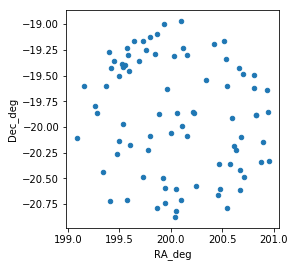

In [50]:
ax = new_observations.plot(x="RA_deg", y="Dec_deg", kind="scatter")
ax.set_aspect("equal")

In [51]:
new_observations.plot()

,obs_id,exp_mjd,night,RA_deg,Dec_deg,obs_x_au,obs_y_au,obs_z_au,mag,name,Delta_au,r_au,obj_x_au,obj_y_au,obj_z_au,obj_dx/dt_au_p_day,obj_dy/dt_au_p_day,obj_dz/dt_au_p_day,theta_x_deg,theta_y_deg
3485,454340,59583.173,59583,199.155365,-19.601792,-0.229001,0.956326,-0.000077,19.298943,14657,3.330941,3.280676,-3.193165,-0.432856,-0.615765,0.002408,-0.007968,-0.000079,-20.557729,-0.871488
5905,789450,59583.173,59583,199.864587,-19.091291,-0.229001,0.956326,-0.000077,19.410540,25467,3.084769,3.038538,-2.970650,-0.353820,-0.531753,0.000111,-0.009022,-0.000431,-20.130865,-0.022417
16601,2298189,59583.173,59583,199.941626,-20.740427,-0.229001,0.956326,-0.000077,21.279729,74136,3.149292,3.089003,-2.997609,-0.408913,-0.623755,0.001171,-0.008761,0.000076,-19.385861,-1.560612
17254,2352966,59583.173,59583,200.534257,-19.334491,-0.229001,0.956326,-0.000077,20.332965,75903,2.709747,2.673955,-2.623463,-0.223416,-0.466436,0.000323,-0.010372,-0.001333,-19.227834,-0.061326
19679,2602733,59583.173,59583,200.671512,-20.607944,-0.229001,0.956326,-0.000077,20.425694,83960,3.109067,3.040581,-2.951767,-0.421493,-0.595444,0.003443,-0.008409,0.001894,-18.604736,-1.215002
25366,3428139,59583.173,59583,199.495901,-19.501250,-0.229001,0.956326,-0.000077,20.746039,B0586,3.029225,2.989054,-2.920736,-0.320261,-0.548798,0.001384,-0.009397,0.000373,-20.408434,-0.511501
26791,3568569,59583.173,59583,199.733503,-19.164074,-0.229001,0.956326,-0.000077,20.868650,B5116,3.489278,3.426182,-3.331353,-0.520324,-0.608332,0.001818,-0.008412,-0.000253,-20.386674,-0.025726
34014,4630040,59583.173,59583,200.416725,-19.190260,-0.229001,0.956326,-0.000077,22.009300,E9357,2.615899,2.589182,-2.544341,-0.176427,-0.446166,-0.000234,-0.010101,-0.000234,-19.733928,0.271305
36100,4978046,59583.173,59583,200.575610,-20.358418,-0.229001,0.956326,-0.000077,21.201737,G0583,2.765795,2.719804,-2.656619,-0.262518,-0.520381,0.003198,-0.009380,-0.000164,-19.116635,-0.744961
36913,5070860,59583.173,59583,200.513499,-19.162097,-0.229001,0.956326,-0.000077,20.842146,G3577,3.202651,3.140324,-3.062376,-0.434473,-0.542885,0.001823,-0.009466,0.000130,-19.765731,0.453696


In [ ]:
fig, ax = plt.subplots(1, 1, dpi=200)

for c in cells:
    ax.scatter(*np.degrees(c.gnomonic.T), s=0.5)

In [ ]:
fig.savefig("10dayphasefold_correct_r&v.png")

In [ ]:
df = pd.DataFrame()
for c in cells:
    c.observations["theta_x"] = c.gnomonic[:,0]
    c.observations["theta_y"] = c.gnomonic[:,1]
    df = pd.concat([df, c.observations])
    
a, b = np.unique(df["name"].values, return_inverse=True)
hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())

fig, ax = plt.subplots(1, 1, dpi=200)
ax = df.plot(x="theta_x", y="theta_y", kind="scatter", c=hex_map[b], s=0.5, ax=ax)
_setAxes(ax, "gnomonic")
ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
#fig.savefig("10dayphasefold_correct_r&v_colorByObject.png")

In [ ]:
particles2, cells2 = phaseFold(cell.center, cell.radius, cell.night, real_object["r_au"].values[0] + 0.5, real_object_velocity_ec_cart, real_object_x_e, cell.night + 9)

In [ ]:
df = pd.DataFrame()
for c in cells2:
    c.observations["theta_x"] = c.gnomonic[:,0]
    c.observations["theta_y"] = c.gnomonic[:,1]
    df = pd.concat([df, c.observations])
    
a, b = np.unique(df["name"].values, return_inverse=True)
hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())

fig, ax = plt.subplots(1, 1, dpi=200)
ax = df.plot(x="theta_x", y="theta_y", kind="scatter", c=hex_map[b], s=0.5, ax=ax)
_setAxes(ax, "gnomonic")
ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
fig.savefig("10dayphasefold_incorrect_r+05_correct_v_colorByObject.png")

In [ ]:
particles3, cells3 = phaseFold(cell.center, cell.radius, cell.night, real_object["r_au"].values[0] - 0.5, real_object_velocity_ec_cart, real_object_x_e, cell.night + 9)

In [ ]:
df = pd.DataFrame()
for c in cells3:
    c.observations["theta_x"] = c.gnomonic[:,0]
    c.observations["theta_y"] = c.gnomonic[:,1]
    df = pd.concat([df, c.observations])
    
a, b = np.unique(df["name"].values, return_inverse=True)
hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())

fig, ax = plt.subplots(1, 1, dpi=200)
ax = df.plot(x="theta_x", y="theta_y", kind="scatter", c=hex_map[b], s=0.5, ax=ax)
_setAxes(ax, "gnomonic")
ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
fig.savefig("10dayphasefold_incorrect_r-05_correct_v_colorByObject.png")